In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

C:\Users\UX431\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Estandarización móvil + LEAR + No outliers

In [2]:
df = pd.read_csv("Data\EPFToolbox\DE.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [5]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2012-01-09 00:00:00,34.97,2072.00,16382.00,2012-01-09,0
1,2012-01-09 01:00:00,33.43,1929.75,15410.50,2012-01-09,1
2,2012-01-09 02:00:00,32.74,1856.00,15595.00,2012-01-09,2
3,2012-01-09 03:00:00,32.46,1808.75,16521.00,2012-01-09,3
4,2012-01-09 04:00:00,32.50,1765.75,17700.75,2012-01-09,4
...,...,...,...,...,...,...
52411,2017-12-31 19:00:00,7.92,1300.00,16601.00,2017-12-31,19
52412,2017-12-31 20:00:00,4.06,1261.00,15977.75,2017-12-31,20
52413,2017-12-31 21:00:00,5.30,1243.25,15715.00,2017-12-31,21
52414,2017-12-31 22:00:00,1.86,1250.50,15876.00,2017-12-31,22


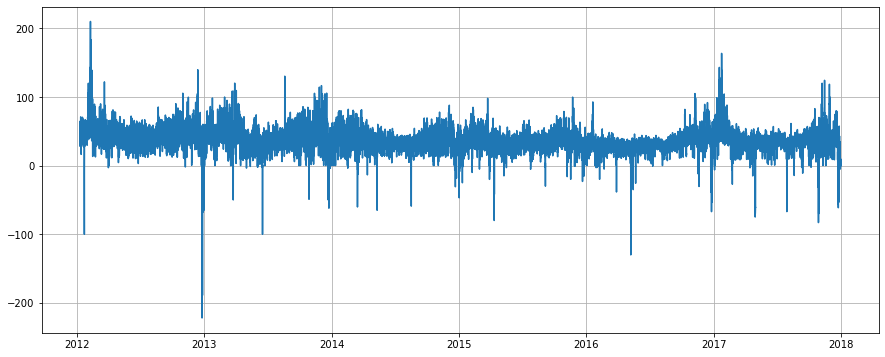

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [7]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [8]:
# df['Price_24'] = df.Price.shift(24)
# df['Price_48'] = df.Price.shift(48)
# df['Price_72'] = df.Price.shift(72)
# df['Price_96'] = df.Price.shift(96)
# df['Price_120'] = df.Price.shift(120)
# df['Price_144'] = df.Price.shift(144)
# df['Price_168'] = df.Price.shift(168)

In [9]:
# df["diff_Price_24"] = df.Price - df.Price_24
# df["lower_quantile_diff_Price_24"] = np.nan
# df["upper_quantile_diff_Price_24"] = np.nan
# for idx in range(len(df)):
#     if idx >= 168:
#         df_aux = df.loc[idx - 168 : idx - 1]
#         df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
#             df.diff_Price_24.dropna().to_numpy(), 0.025
#         )
#         df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
#             df.diff_Price_24.dropna().to_numpy(), 0.975
#         )

# df["outlier"] = 0
# df.loc[
#     (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
#     | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
#     "outlier",
# ] = 1

# df["Price_no_outliers"] = df["Price"]
# col = df.loc[
#     :,
#     [
#         "Price_24",
#         "Price_48",
#         "Price_72",
#         "Price_96",
#         "Price_120",
#         "Price_144",
#         "Price_168",
#     ],
# ]
# df["Price_median"] = col.median(axis=1)
# df.loc[df.outlier == 1, "Price_no_outliers"] = df[
#     df.outlier == 1
# ].Price_median

In [10]:
# df.outlier.sum()

In [11]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.plot(df.Date, df.Price)
# ax.plot(df.Date, df.Price_no_outliers)
# ax.grid()

In [12]:
# names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# for i, x in enumerate(names):
#     df[x] = (pd.to_datetime(df['Simple Date']).dt.weekday == i).astype(int)

In [13]:
# for hora in range(24):
#     df['Price_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Price_hora = df_fecha[df_fecha.Hour == hora].Price.values[0]
        
#         df.loc[df_fecha.index, 'Price_hora_'+str(hora)] = Price_hora

In [14]:
# for col in ['Price_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [15]:
# for hora in range(24):
#     df['Exogenous 1_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_1_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 1'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 1_hora_'+str(hora)] = Exogenous_1_hora

In [16]:
# for hora in range(24):
#     df['Exogenous 2_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_2_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 2'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 2_hora_'+str(hora)] = Exogenous_2_hora

In [17]:
# for col in ['Exogenous 1_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)
# for col in ['Exogenous 2_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [18]:
# list(df.columns)

In [19]:
columnas = ['Date',
 'Price',
 'Price_no_outliers',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
#  'Price_24',
#  'Price_48',
#  'Price_72',
#  'Price_168',
#  'Price_hora_0',
#  'Price_hora_1',
#  'Price_hora_2',
#  'Price_hora_3',
#  'Price_hora_4',
#  'Price_hora_5',
#  'Price_hora_6',
#  'Price_hora_7',
#  'Price_hora_8',
#  'Price_hora_9',
#  'Price_hora_10',
#  'Price_hora_11',
#  'Price_hora_12',
#  'Price_hora_13',
#  'Price_hora_14',
#  'Price_hora_15',
#  'Price_hora_16',
#  'Price_hora_17',
#  'Price_hora_18',
#  'Price_hora_19',
#  'Price_hora_20',
#  'Price_hora_21',
#  'Price_hora_22',
#  'Price_hora_23',
#  'Price_hora_0_24',
#  'Price_hora_0_48',
#  'Price_hora_0_72',
#  'Price_hora_0_168',
#  'Price_hora_1_24',
#  'Price_hora_1_48',
#  'Price_hora_1_72',
#  'Price_hora_1_168',
#  'Price_hora_2_24',
#  'Price_hora_2_48',
#  'Price_hora_2_72',
#  'Price_hora_2_168',
#  'Price_hora_3_24',
#  'Price_hora_3_48',
#  'Price_hora_3_72',
#  'Price_hora_3_168',
#  'Price_hora_4_24',
#  'Price_hora_4_48',
#  'Price_hora_4_72',
#  'Price_hora_4_168',
#  'Price_hora_5_24',
#  'Price_hora_5_48',
#  'Price_hora_5_72',
#  'Price_hora_5_168',
#  'Price_hora_6_24',
#  'Price_hora_6_48',
#  'Price_hora_6_72',
#  'Price_hora_6_168',
#  'Price_hora_7_24',
#  'Price_hora_7_48',
#  'Price_hora_7_72',
#  'Price_hora_7_168',
#  'Price_hora_8_24',
#  'Price_hora_8_48',
#  'Price_hora_8_72',
#  'Price_hora_8_168',
#  'Price_hora_9_24',
#  'Price_hora_9_48',
#  'Price_hora_9_72',
#  'Price_hora_9_168',
#  'Price_hora_10_24',
#  'Price_hora_10_48',
#  'Price_hora_10_72',
#  'Price_hora_10_168',
#  'Price_hora_11_24',
#  'Price_hora_11_48',
#  'Price_hora_11_72',
#  'Price_hora_11_168',
#  'Price_hora_12_24',
#  'Price_hora_12_48',
#  'Price_hora_12_72',
#  'Price_hora_12_168',
#  'Price_hora_13_24',
#  'Price_hora_13_48',
#  'Price_hora_13_72',
#  'Price_hora_13_168',
#  'Price_hora_14_24',
#  'Price_hora_14_48',
#  'Price_hora_14_72',
#  'Price_hora_14_168',
#  'Price_hora_15_24',
#  'Price_hora_15_48',
#  'Price_hora_15_72',
#  'Price_hora_15_168',
#  'Price_hora_16_24',
#  'Price_hora_16_48',
#  'Price_hora_16_72',
#  'Price_hora_16_168',
#  'Price_hora_17_24',
#  'Price_hora_17_48',
#  'Price_hora_17_72',
#  'Price_hora_17_168',
#  'Price_hora_18_24',
#  'Price_hora_18_48',
#  'Price_hora_18_72',
#  'Price_hora_18_168',
#  'Price_hora_19_24',
#  'Price_hora_19_48',
#  'Price_hora_19_72',
#  'Price_hora_19_168',
#  'Price_hora_20_24',
#  'Price_hora_20_48',
#  'Price_hora_20_72',
#  'Price_hora_20_168',
#  'Price_hora_21_24',
#  'Price_hora_21_48',
#  'Price_hora_21_72',
#  'Price_hora_21_168',
#  'Price_hora_22_24',
#  'Price_hora_22_48',
#  'Price_hora_22_72',
#  'Price_hora_22_168',
#  'Price_hora_23_24',
#  'Price_hora_23_48',
#  'Price_hora_23_72',
#  'Price_hora_23_168',
#  'Exogenous 1_hora_0',
#  'Exogenous 1_hora_1',
#  'Exogenous 1_hora_2',
#  'Exogenous 1_hora_3',
#  'Exogenous 1_hora_4',
#  'Exogenous 1_hora_5',
#  'Exogenous 1_hora_6',
#  'Exogenous 1_hora_7',
#  'Exogenous 1_hora_8',
#  'Exogenous 1_hora_9',
#  'Exogenous 1_hora_10',
#  'Exogenous 1_hora_11',
#  'Exogenous 1_hora_12',
#  'Exogenous 1_hora_13',
#  'Exogenous 1_hora_14',
#  'Exogenous 1_hora_15',
#  'Exogenous 1_hora_16',
#  'Exogenous 1_hora_17',
#  'Exogenous 1_hora_18',
#  'Exogenous 1_hora_19',
#  'Exogenous 1_hora_20',
#  'Exogenous 1_hora_21',
#  'Exogenous 1_hora_22',
#  'Exogenous 1_hora_23',
#  'Exogenous 2_hora_0',
#  'Exogenous 2_hora_1',
#  'Exogenous 2_hora_2',
#  'Exogenous 2_hora_3',
#  'Exogenous 2_hora_4',
#  'Exogenous 2_hora_5',
#  'Exogenous 2_hora_6',
#  'Exogenous 2_hora_7',
#  'Exogenous 2_hora_8',
#  'Exogenous 2_hora_9',
#  'Exogenous 2_hora_10',
#  'Exogenous 2_hora_11',
#  'Exogenous 2_hora_12',
#  'Exogenous 2_hora_13',
#  'Exogenous 2_hora_14',
#  'Exogenous 2_hora_15',
#  'Exogenous 2_hora_16',
#  'Exogenous 2_hora_17',
#  'Exogenous 2_hora_18',
#  'Exogenous 2_hora_19',
#  'Exogenous 2_hora_20',
#  'Exogenous 2_hora_21',
#  'Exogenous 2_hora_22',
#  'Exogenous 2_hora_23',
#  'Exogenous 1_hora_0_24',
#  'Exogenous 1_hora_0_168',
#  'Exogenous 1_hora_1_24',
#  'Exogenous 1_hora_1_168',
#  'Exogenous 1_hora_2_24',
#  'Exogenous 1_hora_2_168',
#  'Exogenous 1_hora_3_24',
#  'Exogenous 1_hora_3_168',
#  'Exogenous 1_hora_4_24',
#  'Exogenous 1_hora_4_168',
#  'Exogenous 1_hora_5_24',
#  'Exogenous 1_hora_5_168',
#  'Exogenous 1_hora_6_24',
#  'Exogenous 1_hora_6_168',
#  'Exogenous 1_hora_7_24',
#  'Exogenous 1_hora_7_168',
#  'Exogenous 1_hora_8_24',
#  'Exogenous 1_hora_8_168',
#  'Exogenous 1_hora_9_24',
#  'Exogenous 1_hora_9_168',
#  'Exogenous 1_hora_10_24',
#  'Exogenous 1_hora_10_168',
#  'Exogenous 1_hora_11_24',
#  'Exogenous 1_hora_11_168',
#  'Exogenous 1_hora_12_24',
#  'Exogenous 1_hora_12_168',
#  'Exogenous 1_hora_13_24',
#  'Exogenous 1_hora_13_168',
#  'Exogenous 1_hora_14_24',
#  'Exogenous 1_hora_14_168',
#  'Exogenous 1_hora_15_24',
#  'Exogenous 1_hora_15_168',
#  'Exogenous 1_hora_16_24',
#  'Exogenous 1_hora_16_168',
#  'Exogenous 1_hora_17_24',
#  'Exogenous 1_hora_17_168',
#  'Exogenous 1_hora_18_24',
#  'Exogenous 1_hora_18_168',
#  'Exogenous 1_hora_19_24',
#  'Exogenous 1_hora_19_168',
#  'Exogenous 1_hora_20_24',
#  'Exogenous 1_hora_20_168',
#  'Exogenous 1_hora_21_24',
#  'Exogenous 1_hora_21_168',
#  'Exogenous 1_hora_22_24',
#  'Exogenous 1_hora_22_168',
#  'Exogenous 1_hora_23_24',
#  'Exogenous 1_hora_23_168',
#  'Exogenous 2_hora_0_24',
#  'Exogenous 2_hora_0_168',
#  'Exogenous 2_hora_1_24',
#  'Exogenous 2_hora_1_168',
#  'Exogenous 2_hora_2_24',
#  'Exogenous 2_hora_2_168',
#  'Exogenous 2_hora_3_24',
#  'Exogenous 2_hora_3_168',
#  'Exogenous 2_hora_4_24',
#  'Exogenous 2_hora_4_168',
#  'Exogenous 2_hora_5_24',
#  'Exogenous 2_hora_5_168',
#  'Exogenous 2_hora_6_24',
#  'Exogenous 2_hora_6_168',
#  'Exogenous 2_hora_7_24',
#  'Exogenous 2_hora_7_168',
#  'Exogenous 2_hora_8_24',
#  'Exogenous 2_hora_8_168',
#  'Exogenous 2_hora_9_24',
#  'Exogenous 2_hora_9_168',
#  'Exogenous 2_hora_10_24',
#  'Exogenous 2_hora_10_168',
#  'Exogenous 2_hora_11_24',
#  'Exogenous 2_hora_11_168',
#  'Exogenous 2_hora_12_24',
#  'Exogenous 2_hora_12_168',
#  'Exogenous 2_hora_13_24',
#  'Exogenous 2_hora_13_168',
#  'Exogenous 2_hora_14_24',
#  'Exogenous 2_hora_14_168',
#  'Exogenous 2_hora_15_24',
#  'Exogenous 2_hora_15_168',
#  'Exogenous 2_hora_16_24',
#  'Exogenous 2_hora_16_168',
#  'Exogenous 2_hora_17_24',
#  'Exogenous 2_hora_17_168',
#  'Exogenous 2_hora_18_24',
#  'Exogenous 2_hora_18_168',
#  'Exogenous 2_hora_19_24',
#  'Exogenous 2_hora_19_168',
#  'Exogenous 2_hora_20_24',
#  'Exogenous 2_hora_20_168',
#  'Exogenous 2_hora_21_24',
#  'Exogenous 2_hora_21_168',
#  'Exogenous 2_hora_22_24',
#  'Exogenous 2_hora_22_168',
#  'Exogenous 2_hora_23_24',
#  'Exogenous 2_hora_23_168'
           ]

# columnas_post = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
#        'Saturday', 'Sunday']

In [20]:
def standard_movil(df):
    columnas = list(df.columns)
    dict_new_df = {col: [] for col in columnas}
    columnas.remove('Date')
    columnas.remove('Simple Date')
    columnas.remove('Hour')
    dict_new_df['scaler'] = []
    dict_new_df['scaler_real'] = []
    dict_new_df['Price_real'] = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index >= 168*1:
            dict_new_df['Date'].append(row.Date)
            dict_new_df['Simple Date'].append(row['Simple Date'])
            dict_new_df['Hour'].append(row.Hour)
            df_aux = df[(pd.to_datetime(df['Simple Date']) < pd.to_datetime(row['Simple Date'])) & (pd.to_datetime(df['Simple Date']) >= pd.to_datetime(row['Simple Date']) - dt.timedelta(days=7))]
            for col in columnas:
                df_aux_col = df_aux[col].to_numpy().reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(df_aux_col)
                if col == 'Price':
                    dict_new_df['Price_real'].append(row[col])
                    dict_new_df['scaler_real'].append(scaler)
                elif col == 'Price_no_outliers':
                    dict_new_df['scaler'].append(scaler)
                dict_new_df[col].append(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0])
    return dict_new_df

In [21]:
dict_new_df = standard_movil(df[columnas])

100%|████████████████████████████████████████████████████████████████████████████| 52416/52416 [16:57<00:00, 51.51it/s]


In [26]:
# df = df.drop(df.head(168).index)

In [22]:
with open('dict_new_df_de_epftoolbox_final_no_outliers.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

In [23]:
# df = df.drop(df.head(168).index)

In [24]:
# with open('dict_new_df_espana_epftoolbox_final_no_outliers.pkl', 'rb') as handle:
#     dict_new_df = pickle.load(handle)

In [25]:
for k, v in dict_new_df.items():
    print(k, len(v))

Date 52248
Price 52248
Price_no_outliers 52248
Exogenous 1 52248
Exogenous 2 52248
Simple Date 52248
Hour 52248
scaler 52248
scaler_real 52248
Price_real 52248


In [26]:
df_nuevo = pd.DataFrame(dict_new_df)

In [27]:
df_nuevo

,Date,Price,Price_no_outliers,Exogenous 1,Exogenous 2,Simple Date,Hour,scaler,scaler_real,Price_real
0,2012-01-16 00:00:00,-0.132958,-0.132958,-1.232569,-1.335008,2012-01-16,0,StandardScaler(),StandardScaler(),41.94
1,2012-01-16 01:00:00,-0.356336,-0.356336,-1.234168,-1.524167,2012-01-16,1,StandardScaler(),StandardScaler(),39.69
2,2012-01-16 02:00:00,-0.524119,-0.524119,-1.225008,-1.578075,2012-01-16,2,StandardScaler(),StandardScaler(),38.00
3,2012-01-16 03:00:00,-0.962934,-0.962934,-1.217520,-1.516710,2012-01-16,3,StandardScaler(),StandardScaler(),33.58
4,2012-01-16 04:00:00,-0.973854,-0.973854,-1.215847,-1.427774,2012-01-16,4,StandardScaler(),StandardScaler(),33.47
...,...,...,...,...,...,...,...,...,...,...
52243,2017-12-31 19:00:00,-0.227012,-0.227012,1.163122,-0.581634,2017-12-31,19,StandardScaler(),StandardScaler(),7.92
52244,2017-12-31 20:00:00,-0.395554,-0.395554,1.038015,-0.798149,2017-12-31,20,StandardScaler(),StandardScaler(),4.06
52245,2017-12-31 21:00:00,-0.341411,-0.341411,0.981075,-0.889427,2017-12-31,21,StandardScaler(),StandardScaler(),5.30
52246,2017-12-31 22:00:00,-0.491614,-0.491614,1.004333,-0.833496,2017-12-31,22,StandardScaler(),StandardScaler(),1.86


In [28]:
# for col in columnas_post:
#     df_nuevo[col] = df[col].to_numpy()

In [29]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler_real']})

In [30]:
df_scalers

,Date,scaler
0,2012-01-16 00:00:00,StandardScaler()
1,2012-01-16 01:00:00,StandardScaler()
2,2012-01-16 02:00:00,StandardScaler()
3,2012-01-16 03:00:00,StandardScaler()
4,2012-01-16 04:00:00,StandardScaler()
...,...,...
52243,2017-12-31 19:00:00,StandardScaler()
52244,2017-12-31 20:00:00,StandardScaler()
52245,2017-12-31 21:00:00,StandardScaler()
52246,2017-12-31 22:00:00,StandardScaler()


In [31]:
df_nuevo['outlier'] = 0
df_nuevo['Price_no_outliers'] = df_nuevo.Price
for idx in df_nuevo.index:
    date = df_nuevo.loc[idx, 'Date']
    scaler = df_scalers[df_scalers.Date == date].scaler.values[0]
    std = scaler.scale_[0]
    mean = scaler.mean_[0]
    price = df_nuevo.loc[idx, 'Price_real']
    if price - mean > 3*std:
        df_nuevo.loc[idx, 'Price_no_outliers'] = mean+3*std
        df_nuevo.loc[idx, 'outlier'] = 1
    elif price - mean < -3*std:
        df_nuevo.loc[idx, 'Price_no_outliers'] = mean-3*std
        df_nuevo.loc[idx, 'outlier'] = 1
    else:
        df_nuevo.loc[idx, 'Price_no_outliers'] = price

In [32]:
df_nuevo.outlier.sum() / len(df_nuevo)

0.01519675394273465

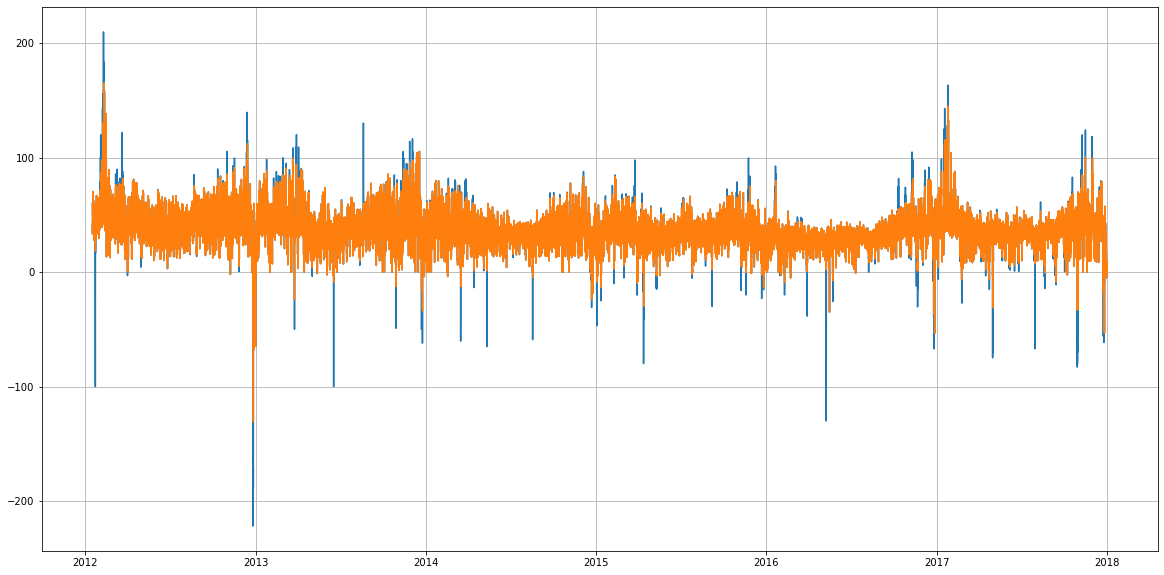

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df_nuevo.Date, df_nuevo.Price_real)
ax.plot(df_nuevo.Date, df_nuevo.Price_no_outliers)
ax.grid()

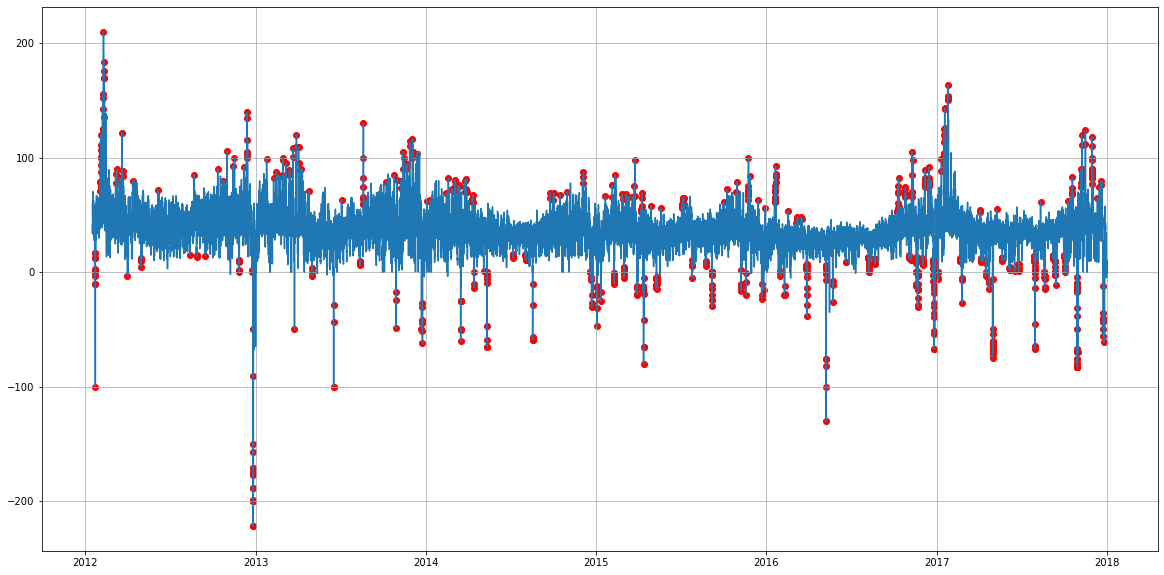

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df_nuevo.Date, df_nuevo.Price_real)
ax.scatter(df_nuevo[df_nuevo.outlier == 1].Date, df_nuevo[df_nuevo.outlier == 1].Price_real, c='r')
ax.grid()

In [35]:
df_nuevo

,Date,Price,Price_no_outliers,Exogenous 1,Exogenous 2,Simple Date,Hour,scaler,scaler_real,Price_real,outlier
0,2012-01-16 00:00:00,-0.132958,41.94,-1.232569,-1.335008,2012-01-16,0,StandardScaler(),StandardScaler(),41.94,0
1,2012-01-16 01:00:00,-0.356336,39.69,-1.234168,-1.524167,2012-01-16,1,StandardScaler(),StandardScaler(),39.69,0
2,2012-01-16 02:00:00,-0.524119,38.00,-1.225008,-1.578075,2012-01-16,2,StandardScaler(),StandardScaler(),38.00,0
3,2012-01-16 03:00:00,-0.962934,33.58,-1.217520,-1.516710,2012-01-16,3,StandardScaler(),StandardScaler(),33.58,0
4,2012-01-16 04:00:00,-0.973854,33.47,-1.215847,-1.427774,2012-01-16,4,StandardScaler(),StandardScaler(),33.47,0
...,...,...,...,...,...,...,...,...,...,...,...
52243,2017-12-31 19:00:00,-0.227012,7.92,1.163122,-0.581634,2017-12-31,19,StandardScaler(),StandardScaler(),7.92,0
52244,2017-12-31 20:00:00,-0.395554,4.06,1.038015,-0.798149,2017-12-31,20,StandardScaler(),StandardScaler(),4.06,0
52245,2017-12-31 21:00:00,-0.341411,5.30,0.981075,-0.889427,2017-12-31,21,StandardScaler(),StandardScaler(),5.30,0
52246,2017-12-31 22:00:00,-0.491614,1.86,1.004333,-0.833496,2017-12-31,22,StandardScaler(),StandardScaler(),1.86,0


In [36]:
df_nuevo = df_nuevo[['Date', 'Price_real', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']].rename(columns={'Price_real':'Price'})

In [37]:
df_nuevo['Exogenous 1'] = df['Exogenous 1']
df_nuevo['Exogenous 2'] = df['Exogenous 2']

In [38]:
df_nuevo

,Date,Price,Price_no_outliers,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2012-01-16 00:00:00,41.94,41.94,2072.00,16382.00,2012-01-16,0
1,2012-01-16 01:00:00,39.69,39.69,1929.75,15410.50,2012-01-16,1
2,2012-01-16 02:00:00,38.00,38.00,1856.00,15595.00,2012-01-16,2
3,2012-01-16 03:00:00,33.58,33.58,1808.75,16521.00,2012-01-16,3
4,2012-01-16 04:00:00,33.47,33.47,1765.75,17700.75,2012-01-16,4
...,...,...,...,...,...,...,...
52243,2017-12-31 19:00:00,7.92,7.92,1286.25,19232.00,2017-12-31,19
52244,2017-12-31 20:00:00,4.06,4.06,1265.50,18533.50,2017-12-31,20
52245,2017-12-31 21:00:00,5.30,5.30,1236.00,18048.50,2017-12-31,21
52246,2017-12-31 22:00:00,1.86,1.86,1194.50,17984.25,2017-12-31,22


In [39]:
dict_new_df = standard_movil(df_nuevo[columnas])

100%|████████████████████████████████████████████████████████████████████████████| 52248/52248 [16:33<00:00, 52.58it/s]


In [40]:
# df_nuevo = df_nuevo.drop(df_nuevo.head(168).index)

In [41]:
with open('dict_new_df_de_epftoolbox_final_no_outliers.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

In [42]:
# df = df.drop(df.head(168).index)

In [43]:
# with open('dict_new_df_espana_epftoolbox_final_no_outliers.pkl', 'rb') as handle:
#     dict_new_df = pickle.load(handle)

In [44]:
for k, v in dict_new_df.items():
    print(k, len(v))

Date 52080
Price 52080
Price_no_outliers 52080
Exogenous 1 52080
Exogenous 2 52080
Simple Date 52080
Hour 52080
scaler 52080
scaler_real 52080
Price_real 52080


In [45]:
df_nuevo = pd.DataFrame(dict_new_df)

In [46]:
df_nuevo

,Date,Price,Price_no_outliers,Exogenous 1,Exogenous 2,Simple Date,Hour,scaler,scaler_real,Price_real
0,2012-01-23 00:00:00,-0.489312,-0.907496,-1.232569,-1.335008,2012-01-23,0,StandardScaler(),StandardScaler(),31.97
1,2012-01-23 01:00:00,-0.526256,-0.964839,-1.234168,-1.524167,2012-01-23,1,StandardScaler(),StandardScaler(),31.32
2,2012-01-23 02:00:00,-0.547285,-0.997481,-1.225008,-1.578075,2012-01-23,2,StandardScaler(),StandardScaler(),30.95
3,2012-01-23 03:00:00,-0.712678,-1.254202,-1.217520,-1.516710,2012-01-23,3,StandardScaler(),StandardScaler(),28.04
4,2012-01-23 04:00:00,-0.713815,-1.255967,-1.215847,-1.427774,2012-01-23,4,StandardScaler(),StandardScaler(),28.02
...,...,...,...,...,...,...,...,...,...,...
52075,2017-12-31 19:00:00,-0.227012,-0.311516,2.778785,-0.934772,2017-12-31,19,StandardScaler(),StandardScaler(),7.92
52076,2017-12-31 20:00:00,-0.395554,-0.500678,2.716505,-1.157646,2017-12-31,20,StandardScaler(),StandardScaler(),4.06
52077,2017-12-31 21:00:00,-0.341411,-0.439911,2.627962,-1.312398,2017-12-31,21,StandardScaler(),StandardScaler(),5.30
52078,2017-12-31 22:00:00,-0.491614,-0.608491,2.503401,-1.332899,2017-12-31,22,StandardScaler(),StandardScaler(),1.86


In [47]:
# for col in columnas_post:
#     df_nuevo[col] = df[col].to_numpy()

In [48]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [49]:
df_scalers

,Date,scaler
0,2012-01-23 00:00:00,StandardScaler()
1,2012-01-23 01:00:00,StandardScaler()
2,2012-01-23 02:00:00,StandardScaler()
3,2012-01-23 03:00:00,StandardScaler()
4,2012-01-23 04:00:00,StandardScaler()
...,...,...
52075,2017-12-31 19:00:00,StandardScaler()
52076,2017-12-31 20:00:00,StandardScaler()
52077,2017-12-31 21:00:00,StandardScaler()
52078,2017-12-31 22:00:00,StandardScaler()


In [50]:
df_nuevo = df_nuevo[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [51]:
df = df_nuevo

In [52]:
df.index = df.Date

In [53]:
df = df.drop(['Date'], axis = 1)

In [54]:
df_train = df[df.index < dt.datetime(2016, 1, 1)]
df_test = df[df.index >= dt.datetime(2016, 1, 1)]

In [55]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [56]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [57]:
forecast_dates = forecast.index

In [58]:
from epftoolbox.models._lear import LEAR_adaptive_normalization as LEAR

In [59]:
calibration_window = 2*364

In [60]:
model = LEAR(calibration_window=calibration_window)

In [61]:
df_scalers[(df_scalers.Date >= forecast_dates[0]) & (df_scalers.Date <= forecast_dates[0] + pd.Timedelta(hours=23))].scaler.to_numpy()

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler()], dtype=object)

In [62]:
df_original = pd.read_csv(r"Data\EPFToolbox\DE.csv")

In [63]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [64]:
df_original.index = df_original.Date

In [65]:
df_original = df_original.drop('Date', axis = 1)

In [66]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [67]:
df_original = df_original[df_original.index >= dt.datetime(2016, 1, 1)]

In [68]:
real_values = df_original[df_original.index >= dt.datetime(2016, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [69]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,23.86,22.39,20.59,16.81,17.41,17.02,15.86,18.16,17.73,19.77,...,25.00,24.43,28.87,37.44,37.41,35.34,33.07,29.52,30.10,24.57
2016-01-02,22.20,16.57,15.35,12.77,11.27,11.91,12.62,13.83,16.12,18.12,...,16.90,16.97,19.25,28.01,28.36,26.56,17.38,15.83,16.97,15.31
2016-01-03,6.99,-0.01,0.23,4.51,4.12,6.76,0.75,4.27,9.11,15.92,...,18.49,16.51,18.76,22.21,26.76,27.08,25.33,22.11,20.91,14.43
2016-01-04,13.78,12.77,10.56,3.87,3.20,8.67,18.01,28.52,34.74,33.46,...,34.94,34.92,38.00,41.21,42.95,41.96,34.94,30.66,30.00,23.90
2016-01-05,25.03,24.42,22.34,21.50,20.00,23.53,28.96,38.32,41.45,40.72,...,34.91,33.50,35.10,42.44,42.94,41.74,36.47,33.01,31.75,26.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,25.37,15.09,13.93,13.48,12.74,13.29,20.03,28.62,32.00,34.91,...,46.40,46.48,50.90,56.09,57.57,51.33,42.40,40.00,42.24,31.27
2017-12-28,28.87,28.12,27.20,26.00,26.33,28.89,30.74,35.98,38.43,39.93,...,36.42,40.03,42.98,43.01,42.16,34.93,25.06,19.99,19.22,5.86
2017-12-29,9.73,0.72,-0.93,1.07,1.00,2.91,3.60,15.97,29.69,30.20,...,30.02,31.00,32.98,34.95,32.79,30.23,28.49,26.51,26.90,15.06


In [ ]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2016-01-01 - sMAPE: 18.87%  |  MAE: 4.457
2016-01-02 - sMAPE: 15.93%  |  MAE: 3.483
2016-01-03 - sMAPE: 23.47%  |  MAE: 3.223
2016-01-04 - sMAPE: 23.45%  |  MAE: 3.588
2016-01-05 - sMAPE: 21.63%  |  MAE: 3.670
2016-01-06 - sMAPE: 20.46%  |  MAE: 3.850
2016-01-07 - sMAPE: 19.24%  |  MAE: 3.868
2016-01-08 - sMAPE: 19.06%  |  MAE: 3.987
2016-01-09 - sMAPE: 18.65%  |  MAE: 3.998
2016-01-10 - sMAPE: 18.01%  |  MAE: 3.820
2016-01-11 - sMAPE: 16.98%  |  MAE: 3.696
2016-01-12 - sMAPE: 16.84%  |  MAE: 3.748
2016-01-13 - sMAPE: 16.12%  |  MAE: 3.640
2016-01-14 - sMAPE: 15.63%  |  MAE: 3.612
2016-01-15 - sMAPE: 15.29%  |  MAE: 3.635
2016-01-16 - sMAPE: 14.88%  |  MAE: 3.555
2016-01-17 - sMAPE: 15.17%  |  MAE: 3.651
2016-01-18 - sMAPE: 15.06%  |  MAE: 3.761
2016-01-19 - sMAPE: 15.74%  |  MAE: 4.223
2016-01-20 - sMAPE: 15.83%  |  MAE: 4.465
2016-01-21 - sMAPE: 15.67%  |  MAE: 4.614
2016-01-22 - sMAPE: 16.13%  |  MAE: 4.907
2016-01-23 - sMAPE: 16.44%  |  MAE: 4.922
2016-01-24 - sMAPE: 16.37%  |  MAE

2016-07-15 - sMAPE: 17.98%  |  MAE: 3.804
2016-07-16 - sMAPE: 17.94%  |  MAE: 3.797
2016-07-17 - sMAPE: 17.89%  |  MAE: 3.787
2016-07-18 - sMAPE: 17.83%  |  MAE: 3.775
2016-07-19 - sMAPE: 17.76%  |  MAE: 3.764
2016-07-20 - sMAPE: 17.71%  |  MAE: 3.757
2016-07-21 - sMAPE: 17.70%  |  MAE: 3.763
2016-07-22 - sMAPE: 17.63%  |  MAE: 3.748
2016-07-23 - sMAPE: 17.59%  |  MAE: 3.742
2016-07-24 - sMAPE: 17.53%  |  MAE: 3.733
2016-07-25 - sMAPE: 17.47%  |  MAE: 3.723
2016-07-26 - sMAPE: 17.41%  |  MAE: 3.711
2016-07-27 - sMAPE: 17.35%  |  MAE: 3.702
2016-07-28 - sMAPE: 17.28%  |  MAE: 3.690
2016-07-29 - sMAPE: 17.23%  |  MAE: 3.681
2016-07-30 - sMAPE: 17.17%  |  MAE: 3.669
2016-07-31 - sMAPE: 17.12%  |  MAE: 3.661
2016-08-01 - sMAPE: 17.08%  |  MAE: 3.655
2016-08-02 - sMAPE: 17.04%  |  MAE: 3.651
2016-08-03 - sMAPE: 17.00%  |  MAE: 3.645
2016-08-04 - sMAPE: 16.96%  |  MAE: 3.639
2016-08-05 - sMAPE: 16.91%  |  MAE: 3.631
2016-08-06 - sMAPE: 16.88%  |  MAE: 3.627
2016-08-07 - sMAPE: 17.07%  |  MAE

2017-01-27 - sMAPE: 17.90%  |  MAE: 4.808
2017-01-28 - sMAPE: 17.91%  |  MAE: 4.815
2017-01-29 - sMAPE: 17.93%  |  MAE: 4.824
2017-01-30 - sMAPE: 17.96%  |  MAE: 4.855
2017-01-31 - sMAPE: 17.94%  |  MAE: 4.861
2017-02-01 - sMAPE: 17.95%  |  MAE: 4.881
2017-02-02 - sMAPE: 17.94%  |  MAE: 4.887
2017-02-03 - sMAPE: 17.92%  |  MAE: 4.885
2017-02-04 - sMAPE: 17.89%  |  MAE: 4.881
2017-02-05 - sMAPE: 17.86%  |  MAE: 4.874
2017-02-06 - sMAPE: 17.85%  |  MAE: 4.882
2017-02-07 - sMAPE: 17.83%  |  MAE: 4.882
2017-02-08 - sMAPE: 17.83%  |  MAE: 4.896
2017-02-09 - sMAPE: 17.80%  |  MAE: 4.894
2017-02-10 - sMAPE: 17.80%  |  MAE: 4.902
2017-02-11 - sMAPE: 17.80%  |  MAE: 4.906
2017-02-12 - sMAPE: 17.79%  |  MAE: 4.905
2017-02-13 - sMAPE: 17.78%  |  MAE: 4.907
2017-02-14 - sMAPE: 17.77%  |  MAE: 4.908
2017-02-15 - sMAPE: 17.74%  |  MAE: 4.904
2017-02-16 - sMAPE: 17.72%  |  MAE: 4.903
2017-02-17 - sMAPE: 17.69%  |  MAE: 4.898


In [ ]:
forecast

In [ ]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_de_epftoolbox_final_2_anos_ventana_no_outliers.csv")

In [ ]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [ ]:
forecast_dates = forecast.index

In [ ]:
calibration_window = 1*364

In [ ]:
model = LEAR(calibration_window=calibration_window)

In [ ]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

In [ ]:
forecast

In [ ]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_de_epftoolbox_final_1_ano_ventana_no_outliers.csv")

In [ ]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [ ]:
forecast_dates = forecast.index

In [ ]:
calibration_window = 182

In [ ]:
model = LEAR(calibration_window=calibration_window)

In [ ]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

In [ ]:
forecast

In [ ]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_de_epftoolbox_final_6_meses_ventana_no_outliers.csv")

In [ ]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [ ]:
forecast_dates = forecast.index

In [ ]:
calibration_window = None

In [ ]:
model = LEAR(calibration_window=calibration_window)

In [ ]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

In [ ]:
forecast

In [ ]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_de_epftoolbox_final_sin_ventana_no_outliers.csv")